# **Q-learning: algoritmo off-policy**

Por: Nicolas Laverde

A continuación, se implementará el algoritmo Q-learning. Este algoritmo es similar a SARSA, sin embargo, la diferencia está en la ecuación iterativa de los valores. SARSA, en cierto modo, es un algoritmo basado en la iteración de políticas, donde lo evaluamos y mejoramos iterativamente. Por otro lado, Q-learning es un algoritmo basado en iteración de valor, donde siempre elegimos la acción óptima para aprender la política óptima. En otras palabras, SARSA utiliza la ecuacion original de Bellman, mientras que Q-learning utiliza la ecuacion **optima** de Bellman, como se muetra en la siguiente imagen:

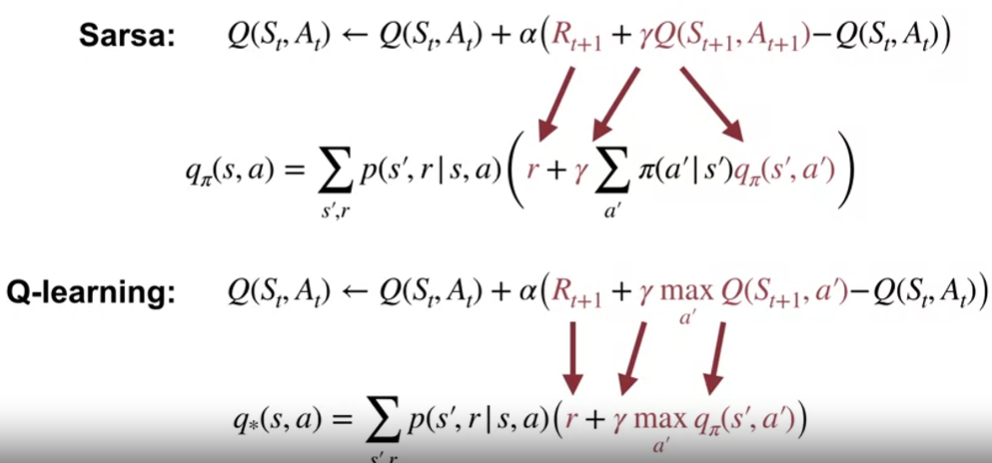

In [ ]:
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt

## **Clases utilizadas**

In [ ]:
class GridWorld:
  def __init__(self, length, width, obj_coo, trap_coo, block_coo, second_obj, start=[0,0]):
    self.length = length
    self.width = width
    self.obj_coo = obj_coo
    self.trap_coo = trap_coo
    self.current_state = start
    self.block_coo = block_coo
    self.second_obj = second_obj
    self.board = [[0 for _ in range(self.width)] for _ in range(self.length)]

    for i in range(len(self.board)):
      for j in range(len(self.board[i])):
        if [i,j] == self.obj_coo:
          self.board[i][j] = 1
        elif [i,j] == self.second_obj:
          self.board[i][j] = 1
        elif (i,j) in self.trap_coo:
          self.board[i][j] = -1
        elif (i,j) in self.block_coo:
          self.board[i][j] = '*'

  def get_current_state(self):
    return self.current_state
  
  def get_posible_actions(self):
    actions = ['up', 'down', 'right', 'left']
    if (self.current_state[0] - 1, self.current_state[1]) in self.block_coo or self.current_state[0]-1 < 0:
      actions.pop(actions.index('up'))
    if (self.current_state[0] + 1, self.current_state[1]) in self.block_coo or self.current_state[0]+1 > self.length-1:
      actions.pop(actions.index('down'))
    if (self.current_state[0], self.current_state[1] + 1) in self.block_coo or self.current_state[1]+1 > self.width-1:
      actions.pop(actions.index('right'))
    if (self.current_state[0], self.current_state[1] - 1) in self.block_coo or self.current_state[1]-1 < 0:
      actions.pop(actions.index('left'))
    
    return actions
  
  def do_action(self, action):
    if action not in self.get_posible_actions():
      raise Exception('No')
    if action == 'up' and self.current_state[0]-1 >= 0:
      self.current_state[0] -= 1
    elif action == 'right' and self.current_state[1]+1 <= self.width-1:
      self.current_state[1] += 1
    elif action == 'down' and self.current_state[0]+1 <= self.length-1:
      self.current_state[0] += 1
    elif action == 'left' and self.current_state[1]-1 >= 0:
      self.current_state[1] -= 1
    
    return (self.board[self.get_current_state()[0]][self.get_current_state()[1]], self.get_current_state())
  
  def reset(self):
    self.current_state = [0,0]
  
  def is_terminal(self):
    return True if self.get_current_state() == self.obj_coo else False

In [ ]:
class SARSA:
  def __init__(self, epsilon, grid):
    self.epsilon = epsilon
    self.grid = grid
    self.states = []
    for i in range(len(self.grid.board)):
      for j in range(len(self.grid.board[0])):
        if (i,j) not in self.grid.block_coo:
          self.states.append([i,j])

  def e_soft_action(self, a, epsilon, actions):
    if np.random.random() < epsilon:
      return np.random.choice(actions)
    else:
      return a

  def greedify(self, po, Q):
    for s in po.keys():
        big = -np.inf
        state = 0
        for key, value in Q[s].items():
          if value > big:
            big = value
            state = key
        a = state
        po[s] = a
    
    return po

  def run_episode(self, po, epsilon, discount, step_size, Q):
    a = self.e_soft_action(po[tuple(self.grid.current_state)], epsilon, self.grid.get_posible_actions())
    s = self.grid.current_state.copy()
    while True:
      next_reward, next_state = self.grid.do_action(a)
      # Agregamos a la recompensa -1 por cada paso para llegar rapido al objetivo
      #next_reward -= 1
      if self.grid.is_terminal():
        Q[tuple(next_state)][a] = 0
        a_prime = self.e_soft_action(po[tuple(next_state)], epsilon, self.grid.get_posible_actions())
        Q[tuple(s)][a] = Q[tuple(s)][a] + step_size*(next_reward + discount*Q[tuple(next_state)][a_prime] - Q[tuple(s)][a])
        po = self.greedify(po, Q)
        break
      else:
        a_prime = self.e_soft_action(po[tuple(next_state)], epsilon, self.grid.get_posible_actions())
        Q[tuple(s)][a] = Q[tuple(s)][a] + step_size*(next_reward + discount*Q[tuple(next_state)][a_prime] - Q[tuple(s)][a])
        po = self.greedify(po, Q)
        s = next_state.copy()
        a = a_prime

    return Q, po
  
  def SARSA_alg(self, step_size, discount):
    po = {}
    for s in self.states:
      self.grid.current_state = s
      po[tuple(s)] = np.random.choice(self.grid.get_posible_actions())
    Q = {}
    for s in self.states:
      self.grid.current_state = s
      Q[tuple(s)] = {}
      for a in self.grid.get_posible_actions():
        Q[tuple(s)][a] = 0
    iter = 0
    delta = float('inf')
    delta_vals = []
    while delta > 0.01:
      self.grid.reset()
      Q_prev = deepcopy(Q)
      Q, po = self.run_episode(po, self.epsilon, discount, step_size, Q)
      delta = 0
      for s in self.states:
        self.grid.current_state = s
        for a in self.grid.get_posible_actions():
          s_tuple = tuple(s)
          delta = max(delta, abs(Q[s_tuple][a] - Q_prev[s_tuple][a]))
      iter += 1
      print(iter)
      delta_vals.append(delta)
    
    V = {}
    for s in po.keys():
      big = -np.inf
      state = 0
      for key, value in Q[s].items():
        if value > big:
          big = value
          state = key
      V[s] = big
    
    for s in po.keys():
      state_copy = list(s)
      self.grid.current_state = state_copy
      V[tuple(self.grid.obj_coo)] = 100
      big_V = float('-inf')
      for action in self.grid.get_posible_actions():
        self.grid.current_state = state_copy[:] 
        _, next_state = self.grid.do_action(action)
        if V[tuple(next_state)] > big_V:
          big_V = V[tuple(next_state)]
          po[s] = action

    return V, po, delta_vals

## **Implementacion Q-learning en GridWorld**

In [ ]:
class Q_learning(SARSA):
  def __init__(self, epsilon, grid):
    self.epsilon = epsilon
    self.grid = grid
    self.states = []
    for i in range(len(self.grid.board)):
      for j in range(len(self.grid.board[0])):
        if (i,j) not in self.grid.block_coo:
          self.states.append([i,j])

  def e_soft_action(self, a, epsilon, actions):
    if np.random.random() < epsilon:
      return np.random.choice(actions)
    else:
      return a
  
  def run_episode(self, Q, po, epsilon, discount, step_size):
    s = self.grid.current_state.copy()
    a = self.e_soft_action(po[tuple(s)], epsilon, self.grid.get_posible_actions())
    while True:
      next_reward, next_state = self.grid.do_action(a)
      if self.grid.is_terminal():
        Q[tuple(next_state)][a] = 0
        next_max = max(Q[tuple(next_state)].values())
        Q[tuple(s)][a] = Q[tuple(s)][a] + step_size*(next_reward + discount*next_max - Q[tuple(s)][a])
        po = self.greedify(po, Q)
        break
      else:
        next_max = max(Q[tuple(next_state)].values())
        Q[tuple(s)][a] = Q[tuple(s)][a] + step_size*(next_reward + discount*next_max - Q[tuple(s)][a])
        po = self.greedify(po, Q)
        s = next_state.copy()
        a = self.e_soft_action(po[tuple(next_state)], epsilon, self.grid.get_posible_actions())

    return Q, po
  
  def Q_learning_alg(self, step_size, discount):
    po = {}
    for s in self.states:
      self.grid.current_state = s
      po[tuple(s)] = np.random.choice(self.grid.get_posible_actions())
    Q = {}
    for s in self.states:
      self.grid.current_state = s
      Q[tuple(s)] = {}
      for a in self.grid.get_posible_actions():
        Q[tuple(s)][a] = 1
    iter = 0
    delta = float('inf')
    delta_vals = []
    while delta > 0.01:
      # Para correr el algoritmo del laberinto se debe descomentar el metodo de reset() con los estados como parametro y comentar el anterior
      self.grid.reset()
      #self.grid.reset(self.states)
      Q_prev = deepcopy(Q)
      Q, po = self.run_episode(Q, po, self.epsilon, discount, step_size)
      delta = 0
      for s in self.states:
        self.grid.current_state = s
        for a in self.grid.get_posible_actions():
          s_tuple = tuple(s)
          delta = max(delta, abs(Q[s_tuple][a] - Q_prev[s_tuple][a]))
      iter += 1
      print(iter)
      delta_vals.append(delta)
    
    V = {}
    for s in po.keys():
      big = -np.inf
      state = 0
      for key, value in Q[s].items():
        if value > big:
          big = value
          state = key
      V[s] = big
    
    for s in po.keys():
      state_copy = list(s)
      self.grid.current_state = state_copy
      V[tuple(self.grid.obj_coo)] = 100
      big_V = float('-inf')
      for action in self.grid.get_posible_actions():
        self.grid.current_state = state_copy[:] 
        _, next_state = self.grid.do_action(action)
        if V[tuple(next_state)] > big_V:
          big_V = V[tuple(next_state)]
          po[s] = action

    return Q, V, po, delta_vals

    

In [ ]:
grid = GridWorld(10, 10, [5,5], {(4,5),(7,5),(7,6)}, [(2,1),(2,2),(2,3),(2,4),(2,6),(2,7),(2,8),(3,4),(4,4),(5,4),(6,4),(7,4)], second_obj=[])

In [ ]:
grid.board

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, '*', '*', '*', '*', 0, '*', '*', '*', 0],
 [0, 0, 0, 0, '*', 0, 0, 0, 0, 0],
 [0, 0, 0, 0, '*', -1, 0, 0, 0, 0],
 [0, 0, 0, 0, '*', 1, 0, 0, 0, 0],
 [0, 0, 0, 0, '*', 0, 0, 0, 0, 0],
 [0, 0, 0, 0, '*', -1, -1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

Utilizamos los siguientes parametros: epsilon = 0.25, step_size = 0.2 y discount = 0.5. Corremos el algoritmo hasta la convergencia (delta < 0.01)

In [ ]:
agent = Q_learning(0.25, grid)

In [ ]:
Q, V, po, delta_vals = agent.Q_learning_alg(0.2, 0.5)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


Politica obtenida

In [ ]:
po

{(0, 0): 'down',
 (0, 1): 'right',
 (0, 2): 'right',
 (0, 3): 'right',
 (0, 4): 'right',
 (0, 5): 'right',
 (0, 6): 'right',
 (0, 7): 'right',
 (0, 8): 'down',
 (0, 9): 'down',
 (1, 0): 'down',
 (1, 1): 'right',
 (1, 2): 'right',
 (1, 3): 'right',
 (1, 4): 'right',
 (1, 5): 'down',
 (1, 6): 'right',
 (1, 7): 'right',
 (1, 8): 'right',
 (1, 9): 'down',
 (2, 0): 'down',
 (2, 5): 'down',
 (2, 9): 'down',
 (3, 0): 'down',
 (3, 1): 'down',
 (3, 2): 'down',
 (3, 3): 'down',
 (3, 5): 'down',
 (3, 6): 'down',
 (3, 7): 'down',
 (3, 8): 'left',
 (3, 9): 'left',
 (4, 0): 'down',
 (4, 1): 'down',
 (4, 2): 'down',
 (4, 3): 'down',
 (4, 5): 'down',
 (4, 6): 'down',
 (4, 7): 'down',
 (4, 8): 'left',
 (4, 9): 'left',
 (5, 0): 'down',
 (5, 1): 'down',
 (5, 2): 'down',
 (5, 3): 'down',
 (5, 5): 'right',
 (5, 6): 'left',
 (5, 7): 'left',
 (5, 8): 'left',
 (5, 9): 'left',
 (6, 0): 'down',
 (6, 1): 'down',
 (6, 2): 'down',
 (6, 3): 'down',
 (6, 5): 'up',
 (6, 6): 'up',
 (6, 7): 'left',
 (6, 8): 'left',
 (6

**Tabla Q valores**

In [ ]:
Q

{(0, 0): {'down': 0.0106364606455937, 'right': 0.010365710493395604},
 (0, 1): {'down': 0.015283436334676463,
  'right': 0.015629444289662897,
  'left': 0.015143158025315573},
 (0, 2): {'down': 0.020218581620433527,
  'right': 0.021755228676020654,
  'left': 0.021941701766574135},
 (0, 3): {'down': 0.031262452876738685,
  'right': 0.030216225749391517,
  'left': 0.02710506950940608},
 (0, 4): {'down': 0.039707985543917024,
  'right': 0.041094689144070246,
  'left': 0.039944596568265156},
 (0, 5): {'down': 0.05439784631618289,
  'right': 0.057467809154315805,
  'left': 0.05349712549088033},
 (0, 6): {'down': 0.07351006469692643,
  'right': 0.07150653384323162,
  'left': 0.06659941412472294},
 (0, 7): {'down': 0.07666325422751244,
  'right': 0.07856379262623864,
  'left': 0.08176982248329337},
 (0, 8): {'down': 0.10375434814341375,
  'right': 0.07965983700960708,
  'left': 0.08763480044421113},
 (0, 9): {'down': 0.0924812439378147, 'left': 0.09568310779689972},
 (1, 0): {'up': 0.01354535

**Valores V**

In [ ]:
V

{(0, 0): 0.0106364606455937,
 (0, 1): 0.015629444289662897,
 (0, 2): 0.021941701766574135,
 (0, 3): 0.031262452876738685,
 (0, 4): 0.041094689144070246,
 (0, 5): 0.057467809154315805,
 (0, 6): 0.07351006469692643,
 (0, 7): 0.08176982248329337,
 (0, 8): 0.10375434814341375,
 (0, 9): 0.09568310779689972,
 (1, 0): 0.015996875046333715,
 (1, 1): 0.017139852482600523,
 (1, 2): 0.022971401677916017,
 (1, 3): 0.031219977783667897,
 (1, 4): 0.0424748944845246,
 (1, 5): 0.06764825308555446,
 (1, 6): 0.07596142793415318,
 (1, 7): 0.08111070005238492,
 (1, 8): 0.09882859413298299,
 (1, 9): 0.11383066287403693,
 (2, 0): 0.023063726500661085,
 (2, 5): 0.11612144326697728,
 (2, 9): 0.15715127759520953,
 (3, 0): 0.03528434196148204,
 (3, 1): 0.03935554151177881,
 (3, 2): 0.04482154515532522,
 (3, 3): 0.04303143282170688,
 (3, 5): 0.20196681935340324,
 (3, 6): 0.38101839973927987,
 (3, 7): 0.39458907924655495,
 (3, 8): 0.31110678998179536,
 (3, 9): 0.22296714037693102,
 (4, 0): 0.04363118734121014,
 (

In [ ]:
V.values()

dict_values([0.0106364606455937, 0.015629444289662897, 0.021941701766574135, 0.031262452876738685, 0.041094689144070246, 0.057467809154315805, 0.07351006469692643, 0.08176982248329337, 0.10375434814341375, 0.09568310779689972, 0.015996875046333715, 0.017139852482600523, 0.022971401677916017, 0.031219977783667897, 0.0424748944845246, 0.06764825308555446, 0.07596142793415318, 0.08111070005238492, 0.09882859413298299, 0.11383066287403693, 0.023063726500661085, 0.11612144326697728, 0.15715127759520953, 0.03528434196148204, 0.03935554151177881, 0.04482154515532522, 0.04303143282170688, 0.20196681935340324, 0.38101839973927987, 0.39458907924655495, 0.31110678998179536, 0.22296714037693102, 0.04363118734121014, 0.04600296899106211, 0.04806418986686748, 0.04815757378076511, 1.45705032704, 0.7467523662437293, 0.49769353214284096, 0.36898135731840004, 0.30012796654717766, 0.049600679021338155, 0.050475762093571665, 0.053110814573119544, 0.05474306548380133, 100, 1.4998377407231707, 0.74820969839

Visualizamos los valores V en el GridWorld

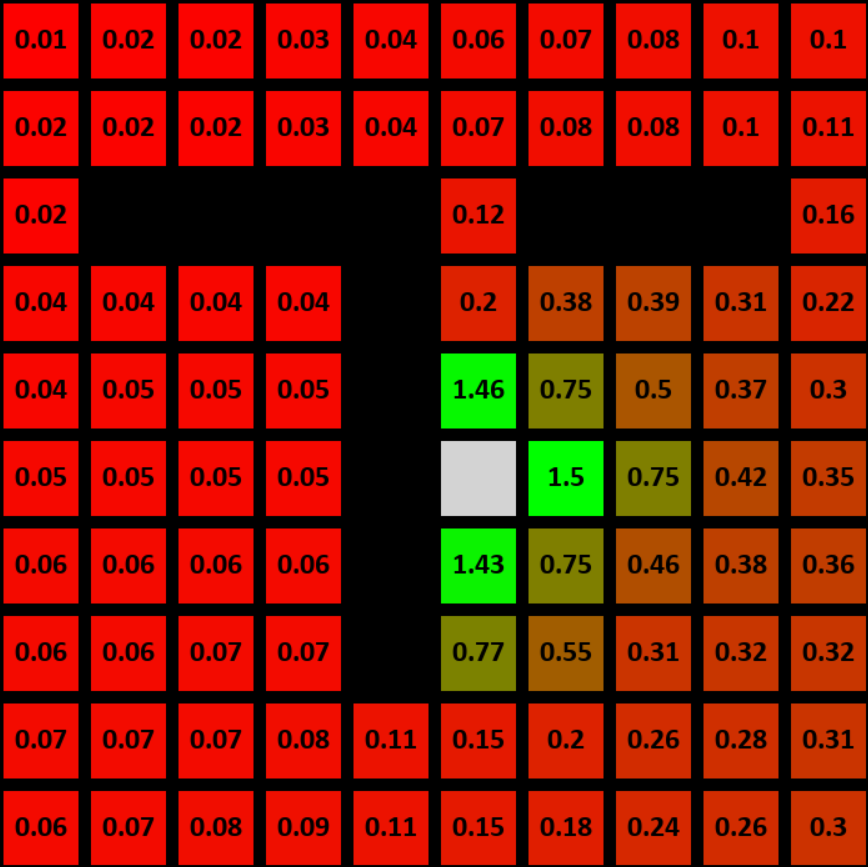

Ahora comparamos SARSA con Q-learning, especificamente en cuanto al numero de iteraciones que toma cada algoritmo para converger.

In [ ]:
Q, V, po, delta_vals = agent.Q_learning_alg(0.2, 0.5)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [ ]:
delta_vals

[1,
 0.30000000000000004,
 0.320623,
 1,
 0.54,
 0.34408409968,
 0.1284875173424,
 0.21312684559846318,
 0.378,
 0.16664599999999996,
 0.1721,
 0.182,
 0.07025700000000001,
 0.1303263,
 0.11944791781107911,
 0.31000000000000005,
 0.18557870704,
 0.11005169515604707,
 0.09502272,
 0.08581382304000001,
 0.113965484,
 0.11481586999999999,
 0.09218709999999997,
 0.022424492441599997,
 0.0715540805758968,
 0.033721033183543025,
 0.0826874876,
 0.02304025377096841,
 0.16864800000000002,
 0.09352757242052917,
 0.1376,
 0.08455239999999997,
 0.08350235708184,
 0.0621460334592,
 0.07549989964704296,
 0.07230431454399999,
 0.05720451248779651,
 0.00873606945588798]

In [ ]:
sarsa_agent = SARSA(0.25, grid)

In [ ]:
_, _, delta_vals_sars = sarsa_agent.SARSA_alg(0.2, 0.5)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


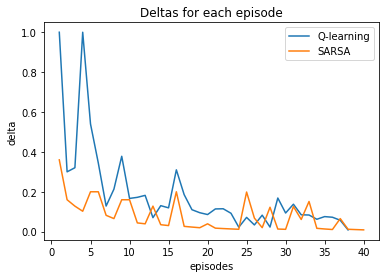

In [ ]:
episodes_q = np.arange(1, 39, 1)
plt.plot(episodes_q, delta_vals, label='Q-learning')
episodes_sarsa = np.arange(1, 41, 1)
plt.plot(episodes_sarsa, delta_vals_sars, label='SARSA')
plt.legend(loc='upper right')
plt.xlabel('episodes')
plt.ylabel('delta')
plt.title('Deltas for each episode')
plt.show()

Del gráfico anterior podemos ver que ambos algoritmos convergen casi al mismo tiempo (Q-learning: 38, SARSA: 40). En teoría se dice que Q-learning es más rápido, sin embargo esto depende mucho de los hiperparámetros que elijamos para cada algoritmo. Con una buena búsqueda de estos, SARSA tiene un rendimiento similar a Q-learning.

## **Laberinto de cuartos**

Para este ambiente queremos que el agente aprenda a salir por el cuarto superior izquierdo en la menor cantidad de pasos posible. La única restricción de este ambiente es que al final de cada episodio el agente comienza nuevamente en cualquier posicón valida del laberinto. Para lograr esto, cada paso que toma el agente tendra una recompensa negativa.

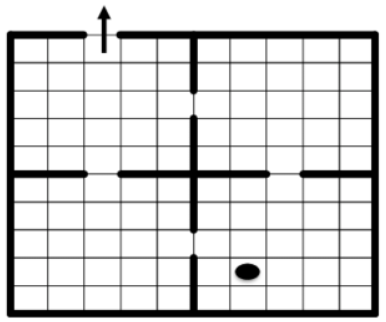

Adicionalmente, se modifica el GridWorld para crear las paredes. Esto lo hacemos modificando la funcion get_possible_actions para quitar las acciones posibles cuando hay una pared. Finalmente, modificamos la funcion reset para que aleatoriamente el agente aparezca en una celda.

**Nota**: Para correr este algoritmo, hay que modificar la clase Q_learning en el metodo Q_learning_alg.

In [ ]:
class Grid_lab(GridWorld):
  def __init__(self, length, width, obj_coo, trap_coo, block_coo, second_obj, start=[0, 0]):
    super().__init__(length, width, obj_coo, trap_coo, block_coo, second_obj, start)
  
  def get_posible_actions(self):
    actions = ['up', 'down', 'right', 'left']
    wall_up = [[5,0],[5,1],[5,3],[5,4],[5,5],[5,6],[5,8],[5,9]]
    wall_down = [[4,0],[4,1],[4,3],[4,4],[4,5],[4,6],[4,8],[4,9]]
    wall_right = [[0,4],[1,4],[3,4],[4,4],[5,4],[6,4],[8,4],[9,4]]
    wall_left = [[0,5],[1,5],[3,5],[4,5],[5,5],[6,5],[8,5],[9,5]]
    if (self.current_state[0] - 1, self.current_state[1]) in self.block_coo or self.current_state[0]-1 < 0 or self.current_state in wall_up:
      actions.pop(actions.index('up'))
    if (self.current_state[0] + 1, self.current_state[1]) in self.block_coo or self.current_state[0]+1 > self.length-1 or self.current_state in wall_down:
      actions.pop(actions.index('down'))
    if (self.current_state[0], self.current_state[1] + 1) in self.block_coo or self.current_state[1]+1 > self.width-1 or self.current_state in wall_right:
      actions.pop(actions.index('right'))
    if (self.current_state[0], self.current_state[1] - 1) in self.block_coo or self.current_state[1]-1 < 0 or self.current_state in wall_left:
      actions.pop(actions.index('left'))
    
    return actions
  
  def reset(self, states):
    states = np.array(states)
    self.current_state = list(states[np.random.choice(len(states),1)][0])

In [ ]:
grid_l = Grid_lab(10, 10, [0,2], {}, {}, [])

In [ ]:
grid_l.board

[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
agent_q = Q_learning(0.25, grid_l)

In [ ]:
Q, V, po, delta_vals = agent_q.Q_learning_alg(0.2, 0.9)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


**Politica**

In [ ]:
po

{(0, 0): 'right',
 (0, 1): 'right',
 (0, 2): 'down',
 (0, 3): 'left',
 (0, 4): 'left',
 (0, 5): 'down',
 (0, 6): 'down',
 (0, 7): 'left',
 (0, 8): 'left',
 (0, 9): 'left',
 (1, 0): 'right',
 (1, 1): 'right',
 (1, 2): 'up',
 (1, 3): 'left',
 (1, 4): 'left',
 (1, 5): 'down',
 (1, 6): 'left',
 (1, 7): 'left',
 (1, 8): 'left',
 (1, 9): 'up',
 (2, 0): 'right',
 (2, 1): 'right',
 (2, 2): 'up',
 (2, 3): 'left',
 (2, 4): 'left',
 (2, 5): 'left',
 (2, 6): 'left',
 (2, 7): 'up',
 (2, 8): 'left',
 (2, 9): 'left',
 (3, 0): 'up',
 (3, 1): 'right',
 (3, 2): 'up',
 (3, 3): 'up',
 (3, 4): 'up',
 (3, 5): 'up',
 (3, 6): 'left',
 (3, 7): 'left',
 (3, 8): 'left',
 (3, 9): 'down',
 (4, 0): 'up',
 (4, 1): 'right',
 (4, 2): 'up',
 (4, 3): 'left',
 (4, 4): 'left',
 (4, 5): 'up',
 (4, 6): 'left',
 (4, 7): 'left',
 (4, 8): 'right',
 (4, 9): 'left',
 (5, 0): 'right',
 (5, 1): 'right',
 (5, 2): 'up',
 (5, 3): 'left',
 (5, 4): 'left',
 (5, 5): 'down',
 (5, 6): 'left',
 (5, 7): 'up',
 (5, 8): 'left',
 (5, 9): 'left

**Tabla Q**

In [ ]:
Q

{(0, 0): {'down': 1, 'right': 0.98},
 (0, 1): {'down': 0.98, 'right': 1.3239999999999998, 'left': 1},
 (0, 2): {'down': 1, 'right': 0, 'left': 0, 'up': 0},
 (0, 3): {'down': 1.0067405696, 'right': 0.95464, 'left': 1.6050879999999998},
 (0, 4): {'down': 0.94472, 'left': 1.00952},
 (0, 5): {'down': 0.8217292442707799, 'right': 0.8154287962598125},
 (0, 6): {'down': 0.826761838842791,
  'right': 0.8150961745982273,
  'left': 0.8201504314443335},
 (0, 7): {'down': 0.815945052048742,
  'right': 0.8069310390447351,
  'left': 0.8220893529964475},
 (0, 8): {'down': 0.7961531295888082,
  'right': 0.8015513334708785,
  'left': 0.8041271058814695},
 (0, 9): {'down': 0.8083895231985178, 'left': 0.7944073712975975},
 (1, 0): {'up': 0.98, 'down': 0.9764, 'right': 1.0361263449486795},
 (1, 1): {'up': 0.9964, 'down': 0.98, 'right': 1.3899562357241606, 'left': 1},
 (1, 2): {'up': 1.8957498701654172,
  'down': 1.0097908710399999,
  'right': 0.96411104,
  'left': 1.02008290097152},
 (1, 3): {'up': 1.2293

**Valores V**

In [ ]:
V

{(0, 0): 1,
 (0, 1): 1.3239999999999998,
 (0, 2): 100,
 (0, 3): 1.6050879999999998,
 (0, 4): 1.00952,
 (0, 5): 0.8217292442707799,
 (0, 6): 0.826761838842791,
 (0, 7): 0.8220893529964475,
 (0, 8): 0.8041271058814695,
 (0, 9): 0.8083895231985178,
 (1, 0): 1.0361263449486795,
 (1, 1): 1.3899562357241606,
 (1, 2): 1.8957498701654172,
 (1, 3): 1.2293262079999998,
 (1, 4): 0.9802269567999999,
 (1, 5): 0.8341506231644985,
 (1, 6): 0.8298677505750854,
 (1, 7): 0.8242816896872694,
 (1, 8): 0.805570757025126,
 (1, 9): 0.8040396250046461,
 (2, 0): 0.97954660736,
 (2, 1): 1.1779467283636043,
 (2, 2): 1.6735676804544237,
 (2, 3): 1.3740219578667738,
 (2, 4): 1.0511383768747662,
 (2, 5): 0.8708833697174994,
 (2, 6): 0.8235582103924567,
 (2, 7): 0.8174872917881855,
 (2, 8): 0.817997250959583,
 (2, 9): 0.8070565072425303,
 (3, 0): 0.958226438278144,
 (3, 1): 0.9783983919326003,
 (3, 2): 1.3459949467454666,
 (3, 3): 1.0172386901209836,
 (3, 4): 0.946952,
 (3, 5): 0.8276940083734446,
 (3, 6): 0.8191815

In [ ]:
V.values()

dict_values([1, 1.3239999999999998, 100, 1.6050879999999998, 1.00952, 0.8217292442707799, 0.826761838842791, 0.8220893529964475, 0.8041271058814695, 0.8083895231985178, 1.0361263449486795, 1.3899562357241606, 1.8957498701654172, 1.2293262079999998, 0.9802269567999999, 0.8341506231644985, 0.8298677505750854, 0.8242816896872694, 0.805570757025126, 0.8040396250046461, 0.97954660736, 1.1779467283636043, 1.6735676804544237, 1.3740219578667738, 1.0511383768747662, 0.8708833697174994, 0.8235582103924567, 0.8174872917881855, 0.817997250959583, 0.8070565072425303, 0.958226438278144, 0.9783983919326003, 1.3459949467454666, 1.0172386901209836, 0.946952, 0.8276940083734446, 0.8191815520643099, 0.8188643950680624, 0.8041791599806317, 0.8069886884819456, 0.94184, 0.9515739825743308, 1.09226618327133, 0.959752, 0.95752, 0.8202703692278269, 0.8217822572932577, 0.8012828717992447, 0.8139033129240111, 0.80865113123022, 0.8306788172840831, 0.8344508003665065, 0.9008268098019832, 0.844916669583533, 0.8269

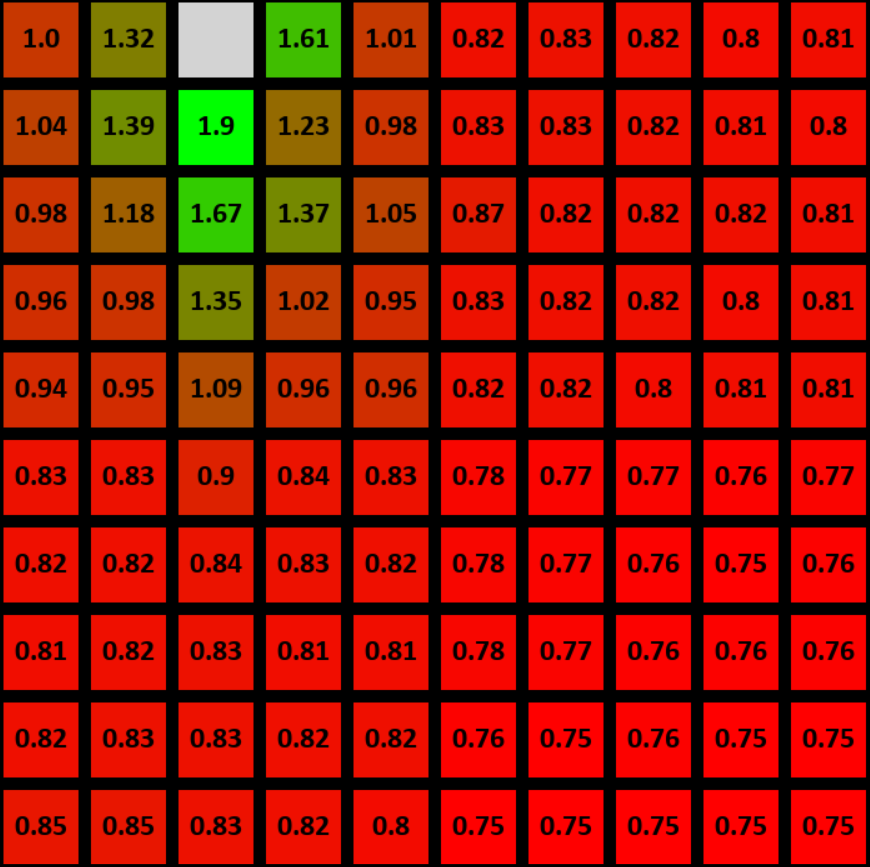

## **Taxi GridWorld**

En este mundo, el agente es un taxi y tiene como objetivo recoger al pasajero y dejarlo en un punto objetivo. Existen 4 paraderos en las que el pasajero puede estar y su objetivo. En primera instancia el pasajero estara fijo en la estacion B y su objetivo sera la estacion R, esto lo hacemos para simplificar el algoritmo y tener un mejor entendimiento de este. A contiunuacion se puede observar el Grid de este mundo.

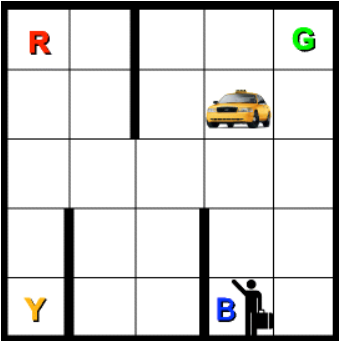

Las acciones del agente corresponden a los movimientos del agente en el tablero y las acciones para recoger y dejar pasajeros. Tratar de recoger o dejar un pasajero en un lugar indebido o cuando no hay pasajero, son consideradas malas accciones del agente y deben ser penalizadas (tienen una recompenza de -10). Para asegurar que el agente efectivamente recoge pasajeros, debemos darle una recompensa de 1 a la acción. Efectivamente dejar al pasajero tiene una recompensa de 5.

Dos cosas hay que implementar en el GridWorld original:
1. Ahora los estados deben incluir si el agente tiene un pasajero o no.
2. Toca incluir las acciones 'recoger' y 'dejar' en el conjunto de acciones dependiendo del estado.

In [ ]:
class TaxiGrid(GridWorld):
  def __init__(self, length, width, obj_coo, trap_coo, block_coo, second_obj, start=[0, 0]):
    super().__init__(length, width, obj_coo, trap_coo, block_coo, second_obj, start)
    self.passenger = False
    self.board_pas = [[0 for _ in range(self.width)] for _ in range(self.length)]
    self.board_not_pas = [[0 for _ in range(self.width)] for _ in range(self.length)]

  def get_posible_actions(self, passenger):
    wall_up = []
    wall_down = []
    wall_right = [[3,0],[4,0],[0,1],[1,1],[3,2],[4,2]]
    wall_left = [[3,1],[4,1],[0,2],[1,2],[3,3],[4,3]]
    if passenger == False:
      actions = ['up', 'down', 'right', 'left', 'pick up']
      if (self.current_state[0] - 1, self.current_state[1]) in self.block_coo or self.current_state[0]-1 < 0 or self.current_state[:-1] in wall_up:
        actions.pop(actions.index('up'))
      if (self.current_state[0] + 1, self.current_state[1]) in self.block_coo or self.current_state[0]+1 > self.length-1 or self.current_state[:-1] in wall_down:
        actions.pop(actions.index('down'))
      if (self.current_state[0], self.current_state[1] + 1) in self.block_coo or self.current_state[1]+1 > self.width-1 or self.current_state[:-1] in wall_right:
        actions.pop(actions.index('right'))
      if (self.current_state[0], self.current_state[1] - 1) in self.block_coo or self.current_state[1]-1 < 0 or self.current_state[:-1] in wall_left:
        actions.pop(actions.index('left'))
    else:
      actions = ['up', 'down', 'right', 'left', 'drop']
      if (self.current_state[0] - 1, self.current_state[1]) in self.block_coo or self.current_state[0]-1 < 0 or self.current_state[:-1] in wall_up:
        actions.pop(actions.index('up'))
      if (self.current_state[0] + 1, self.current_state[1]) in self.block_coo or self.current_state[0]+1 > self.length-1 or self.current_state[:-1] in wall_down:
        actions.pop(actions.index('down'))
      if (self.current_state[0], self.current_state[1] + 1) in self.block_coo or self.current_state[1]+1 > self.width-1 or self.current_state[:-1] in wall_right:
        actions.pop(actions.index('right'))
      if (self.current_state[0], self.current_state[1] - 1) in self.block_coo or self.current_state[1]-1 < 0 or self.current_state[:-1] in wall_left:
        actions.pop(actions.index('left'))
    
    return actions

  def do_action(self, action, passenger, passenger_pick, passenger_drop):
    rewards = 0
    if passenger == False:
      if action not in self.get_posible_actions(passenger):
        raise Exception('No')
      if action == 'up' and self.current_state[0]-1 >= 0:
        self.current_state[0] -= 1
        rewards = -1
      elif action == 'right' and self.current_state[1]+1 <= self.width-1:
        self.current_state[1] += 1
        rewards = -1
      elif action == 'down' and self.current_state[0]+1 <= self.length-1:
        self.current_state[0] += 1
        rewards = -1
      elif action == 'left' and self.current_state[1]-1 >= 0:
        self.current_state[1] -= 1
        rewards = -1
      elif action == 'pick up' and self.current_state == passenger_pick:
        passenger = True
        rewards = 1
      elif action == 'pick up' and self.current_state != passenger_pick:
        rewards = -10
    else:
      if action not in self.get_posible_actions(passenger):
        raise Exception('No')
      if action == 'up' and self.current_state[0]-1 >= 0:
        self.current_state[0] -= 1
        rewards = -1
      elif action == 'right' and self.current_state[1]+1 <= self.width-1:
        self.current_state[1] += 1
        rewards = -1
      elif action == 'down' and self.current_state[0]+1 <= self.length-1:
        self.current_state[0] += 1
        rewards = -1
      elif action == 'left' and self.current_state[1]-1 >= 0:
        self.current_state[1] -= 1
        rewards = -1
      elif action == 'drop' and self.current_state == passenger_drop:
        passenger = False
        rewards = 5
      elif action == 'drop' and self.current_state != passenger_drop:
        rewards = -10
    
    return (rewards, self.get_current_state(), passenger)
  
  def reset(self, states):
    states = np.array(states)
    self.current_state = list(states[np.random.choice(len(states),1)][0])
    self.passenger = False

In [ ]:
class Q_learning_taxi(Q_learning):
  def __init__(self, epsilon, grid):
    self.epsilon = epsilon
    self.grid = grid
    self.states = []
    for i in range(len(self.grid.board_pas)):
      for j in range(len(self.grid.board_pas[0])):
        if (i,j) not in self.grid.block_coo:
          self.states.append([i,j,'with passenger'])
    
    for i in range(len(self.grid.board_not_pas)):
      for j in range(len(self.grid.board_not_pas[0])):
        if (i,j) not in self.grid.block_coo:
          self.states.append([i,j,'without passenger'])

  def e_soft_action(self, a, epsilon, actions):
    if np.random.random() < epsilon:
      return np.random.choice(actions)
    else:
      return a
  
  def run_episode(self, Q, po, epsilon, discount, step_size, passenger):
    passenger = False
    self.grid.current_state = [int(self.grid.current_state[0]), int(self.grid.current_state[1]), self.grid.current_state[2]]
    s = self.grid.current_state.copy()
    x = (int(s[0]), int(s[1]), s[2])
    a = self.e_soft_action(po[x], epsilon, self.grid.get_posible_actions(passenger))
    while passenger == False:
      next_reward, next_state, passenger = self.grid.do_action(a, passenger, [4,3,'without passenger'], [0,0,'with passenger'])
      next_max = max(Q[tuple(next_state)].values())
      Q[tuple(s)][a] = Q[tuple(s)][a] + step_size*(next_reward + discount*next_max - Q[tuple(s)][a])
      po = self.greedify(po, Q)
      z = (int(next_state[0]), int(next_state[1]), next_state[2])
      s = next_state.copy()
      a = self.e_soft_action(po[z], epsilon, self.grid.get_posible_actions(passenger))
    next_state = [next_state[0], next_state[1], 'with passenger']
    self.grid.current_state = next_state
    s = self.grid.current_state.copy()
    a = self.e_soft_action(po[tuple(next_state)], epsilon, self.grid.get_posible_actions(passenger))
    while passenger:
      next_reward, next_state, passenger = self.grid.do_action(a, passenger, [4,3,'without passenger'], [0,0,'with passenger'])
      next_max = max(Q[tuple(next_state)].values())
      Q[tuple(s)][a] = Q[tuple(s)][a] + step_size*(next_reward + discount*next_max - Q[tuple(s)][a])
      po = self.greedify(po, Q)
      w = (int(next_state[0]), int(next_state[1]), next_state[2])
      s = next_state.copy()
      a = self.e_soft_action(po[w], epsilon, self.grid.get_posible_actions(passenger))

    return Q, po
  
  def Q_learning_alg(self, step_size, discount):
    po = {}
    for s in self.states[:len(self.states)//2]:
      self.grid.current_state = s
      po[tuple(s)] = np.random.choice(self.grid.get_posible_actions(True))
    for s in self.states[len(self.states)//2:]:
      self.grid.current_state = s
      po[tuple(s)] = np.random.choice(self.grid.get_posible_actions(False))
    Q_with_p = {}
    Q_not_p = {}
    for s in self.states[:len(self.states)//2]:
      self.grid.current_state = s
      Q_with_p[tuple(s)] = {}
      for a in self.grid.get_posible_actions(True):
        Q_with_p[tuple(s)][a] = 10
    for s in self.states[len(self.states)//2:]:
      self.grid.current_state = s
      Q_not_p[tuple(s)] = {}
      for a in self.grid.get_posible_actions(False):
        Q_not_p[tuple(s)][a] = 10
    Q = Q_with_p | Q_not_p
    iter = 0
    delta = float('inf')
    delta_vals = []
    for _ in range(100):
      # Para correr el algoritmo del laberinto se debe descomentar el metodo de reset() con los estados como parametro y comentar el anterior
      #self.grid.reset()
      self.grid.reset(self.states[len(self.states)//2:])
      Q_prev = deepcopy(Q)
      Q, po = self.run_episode(Q, po, self.epsilon, discount, step_size, self.grid.passenger)
      delta = 0
      for s in self.states[:len(self.states)//2]:
        self.grid.current_state = s
        for a in self.grid.get_posible_actions(True):
          s_tuple = tuple(s)
          delta = max(delta, abs(Q[s_tuple][a] - Q_prev[s_tuple][a]))
      for s in self.states[len(self.states)//2:]:
        self.grid.current_state = s
        for a in self.grid.get_posible_actions(False):
          s_tuple = tuple(s)
          delta = max(delta, abs(Q[s_tuple][a] - Q_prev[s_tuple][a]))
      iter += 1
      print(iter)
      delta_vals.append(delta)
    
    V = {}
    for s in po.keys():
      big = -np.inf
      state = 0
      for key, value in Q[s].items():
        if value > big:
          big = value
          state = key
      V[s] = big
    
    for s in list(po.keys())[:len(po.keys())//2]:
      state_copy = list(s)
      self.grid.current_state = state_copy
      big_V = float('-inf')
      for action in self.grid.get_posible_actions(True):
        self.grid.current_state = state_copy[:] 
        _, next_state, _ = self.grid.do_action(action, True, [4,3,'without passenger'], [0,0,'with passenger'])
        if V[tuple(next_state)] > big_V:
          big_V = V[tuple(next_state)]
          po[s] = action
    
    for s in list(po.keys())[len(po.keys())//2:]:
      state_copy = list(s)
      self.grid.current_state = state_copy
      big_V = float('-inf')
      for action in self.grid.get_posible_actions(False):
        self.grid.current_state = state_copy[:] 
        _, next_state, _ = self.grid.do_action(action, False, [4,3,'without passenger'], [0,0,'with passenger'])
        if V[tuple(next_state)] > big_V:
          big_V = V[tuple(next_state)]
          po[s] = action
      

    return Q, V, po, delta_vals

Ejecutamos el algoritmo con los siguientes parámetros: epsilon = 0.1, step_size = 0.2 y descuento = 1.0. Además, inicializamos los valores Q con 10 para fomentar el escaneo de agentes. Entrenamos para 100 episodios.

In [ ]:
grid_taxi = TaxiGrid(5, 5, [], {}, {}, [], start=[2,1])

In [ ]:
agent_q_taxi = Q_learning_taxi(0.1, grid_taxi)

In [ ]:
Q, V, po, delta_vals = agent_q_taxi.Q_learning_alg(0.2, 1.0)

1
3.6399999999999997
2
3.6399999999999997
3
3.6719999999999997
4
2.0
5
1.7981439999999997
6
1.756608
7
2.0
8
2.0
9
1.0
10
2.0
11
2.0
12
2.0
13
3.1874917279669415
14
1.0
15
1.6851314343935995
16
2.0
17
2.0
18
1.9032169676799997
19
2.0
20
1.0
21
2.0
22
1.0
23
1.675574651229958
24
1.0
25
1.0
26
1.7115562391182024
27
1.489474933965929
28
5.105600000000001
29
1.9021429043985378
30
1.1661287365443265
31
3.3277629503783066
32
1.0945594316973555
33
1.0756475453578815
34
3.071441601006729
35
1.1422117116556727
36
3.37533870856637
37
1.0870337027134394
38
1.024788187662871
39
6.2844799999999985
40
2.1338410324893022
41
1.012691552083389
42
1.010153241666714
43
5.827584000000002
44
1.2451769972406197
45
5.575211190190981
46
3.411295874395412
47
2.932002306688995
48
1.2892314339290998
49
1.2373969430685818
50
8.065728097901163
51
1.1610616380144165
52
5.249653760000001
53
1.1052642853809296
54
4.465679691000492
55
5.292606461671239
56
1.7122721517790715
57
1.111625406739737
58
1.0927446391984326
5

**Politica**

Ahora tenemos 2 estados para cada celda debido a la naturaleza del problema. El numero de estados incrementaria si el paradero y el destino fueran cambiando, ya que tocaria adicionar el paradero y el destino en cada uno.

In [ ]:
po

{(0, 0, 'with passenger'): 'drop',
 (0, 1, 'with passenger'): 'left',
 (0, 2, 'with passenger'): 'down',
 (0, 3, 'with passenger'): 'down',
 (0, 4, 'with passenger'): 'left',
 (1, 0, 'with passenger'): 'up',
 (1, 1, 'with passenger'): 'left',
 (1, 2, 'with passenger'): 'down',
 (1, 3, 'with passenger'): 'down',
 (1, 4, 'with passenger'): 'down',
 (2, 0, 'with passenger'): 'up',
 (2, 1, 'with passenger'): 'up',
 (2, 2, 'with passenger'): 'left',
 (2, 3, 'with passenger'): 'left',
 (2, 4, 'with passenger'): 'left',
 (3, 0, 'with passenger'): 'up',
 (3, 1, 'with passenger'): 'up',
 (3, 2, 'with passenger'): 'up',
 (3, 3, 'with passenger'): 'up',
 (3, 4, 'with passenger'): 'left',
 (4, 0, 'with passenger'): 'up',
 (4, 1, 'with passenger'): 'up',
 (4, 2, 'with passenger'): 'left',
 (4, 3, 'with passenger'): 'up',
 (4, 4, 'with passenger'): 'left',
 (0, 0, 'without passenger'): 'down',
 (0, 1, 'without passenger'): 'down',
 (0, 2, 'without passenger'): 'right',
 (0, 3, 'without passenger'): 

**Tabla Q**

In [ ]:
Q

{(0, 0, 'with passenger'): {'down': 46.403073874862756,
  'right': 16.77181184,
  'drop': 110.0},
 (0, 1, 'with passenger'): {'down': 9.600000000000001,
  'left': 60.0408863744,
  'drop': 8.0},
 (0, 2, 'with passenger'): {'down': 7.481739063394305,
  'right': 7.287448986222593,
  'drop': 6.0},
 (0, 3, 'with passenger'): {'down': 7.198052921805042,
  'right': 7.02196047080902,
  'left': 7.316607028782695,
  'drop': 6.0},
 (0, 4, 'with passenger'): {'down': 7.182914040113872,
  'left': 7.051034001031824,
  'drop': 4.9276800000000005},
 (1, 0, 'with passenger'): {'up': 103.7434673121032,
  'down': 9.802278848201347,
  'right': 32.577988630147196,
  'drop': 15.673162940569288},
 (1, 1, 'with passenger'): {'up': 23.867717939200002,
  'down': 18.970923350066826,
  'left': 97.64017393935724,
  'drop': 9.68893870856637},
 (1, 2, 'with passenger'): {'up': 7.517430666126951,
  'down': 7.7136038387840475,
  'right': 7.1478318092711275,
  'drop': 6.0},
 (1, 3, 'with passenger'): {'up': 7.276915501

**Valores V**

In [ ]:
V.values()

dict_values([110.0, 60.0408863744, 7.481739063394305, 7.316607028782695, 7.182914040113872, 103.7434673121032, 97.64017393935724, 7.7136038387840475, 20.04780414427202, 7.184123678110516, 44.25925106313352, 92.04339738067752, 86.12944227389431, 79.92134721241553, 29.97165015980979, 9.081500160000001, 32.06758860690979, 8.274894188544001, 73.7178427461126, 10.519481117029308, 8.978048000000001, 8.289152819200002, 8.253557268480002, 68.39007817733385, 16.750029714216296, 6.5892876599789085, 7.11120546439011, 8.094370248111899, 13.820154369022926, 9.409562430146169, 7.366278568930149, 9.824083601191386, 10.1011436492688, 20.95006703134623, 10.55628676812233, 12.194875781789214, 18.0707370735728, 23.04997269947042, 25.966445728511943, 13.099121824676493, 7.265097976600569, 9.484067574242035, 18.274692763355386, 27.994677838277312, 15.568600211250667, 6.268785753210466, 7.439956530233344, 11.985263174552351, 29.99999999999993, 18.332588131450848])

In [ ]:
delta_vals

[3.6399999999999997,
 3.6399999999999997,
 3.6719999999999997,
 2.0,
 1.7981439999999997,
 1.756608,
 2.0,
 2.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.1874917279669415,
 1.0,
 1.6851314343935995,
 2.0,
 2.0,
 1.9032169676799997,
 2.0,
 1.0,
 2.0,
 1.0,
 1.675574651229958,
 1.0,
 1.0,
 1.7115562391182024,
 1.489474933965929,
 5.105600000000001,
 1.9021429043985378,
 1.1661287365443265,
 3.3277629503783066,
 1.0945594316973555,
 1.0756475453578815,
 3.071441601006729,
 1.1422117116556727,
 3.37533870856637,
 1.0870337027134394,
 1.024788187662871,
 6.2844799999999985,
 2.1338410324893022,
 1.012691552083389,
 1.010153241666714,
 5.827584000000002,
 1.2451769972406197,
 5.575211190190981,
 3.411295874395412,
 2.932002306688995,
 1.2892314339290998,
 1.2373969430685818,
 8.065728097901163,
 1.1610616380144165,
 5.249653760000001,
 1.1052642853809296,
 4.465679691000492,
 5.292606461671239,
 1.7122721517790715,
 1.111625406739737,
 1.0927446391984326,
 1.0847344014392348,
 9.477874005585868,
 4.391995